# FITS → HD PNG preview\n\nThis notebook loads a FITS file, selects a 2D plane if needed, applies a contrast stretch, and saves an HD PNG.

Raw shape: (1, 31, 256, 256)
Using plane: 0 from stack shape: (31, 256, 256)


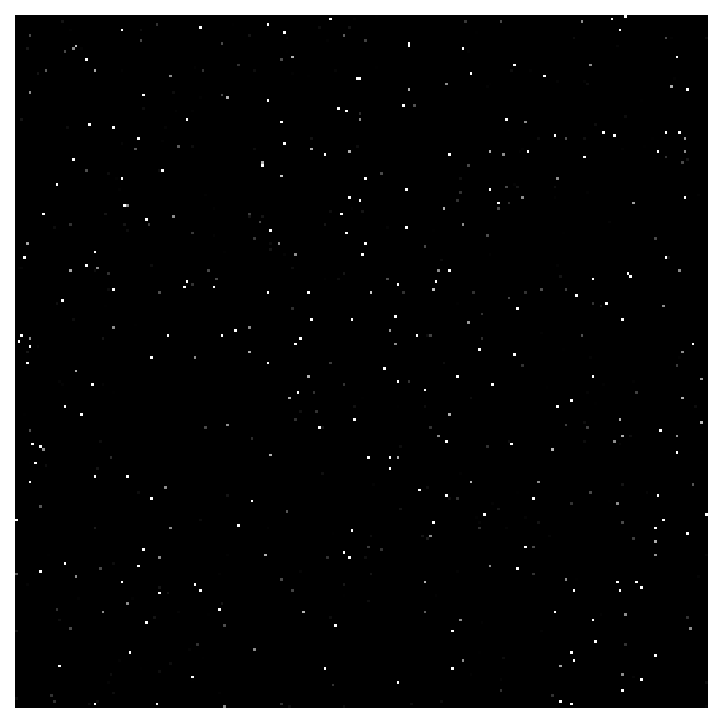

Saved: slice_hd.png


In [1]:
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch

# ---- 1) Load FITS (from disk). Change this path. ----
fits_path = "ngc6503.fits"

with fits.open(fits_path, memmap=False) as hdul:
    data = hdul[0].data

if data is None:
    raise ValueError("No image data in primary HDU (hdul[0].data is None)")

print("Raw shape:", np.shape(data))

# ---- 2) Pick a single 2D plane safely ----
arr = np.asarray(data)
arr = np.squeeze(arr)  # remove length-1 dims, e.g. (1,31,256,256)->(31,256,256)

if arr.ndim < 2:
    raise ValueError(f"Data has ndim={arr.ndim}, expected at least 2D")

if arr.ndim == 2:
    img = arr
else:
    # Flatten any leading dims, keep last two as (Y,X)
    ny, nx = arr.shape[-2], arr.shape[-1]
    stack = arr.reshape(-1, ny, nx)  # e.g. (31,256,256)
    k = 0  # choose plane index (0..stack.shape[0]-1)
    img = stack[k]
    print("Using plane:", k, "from stack shape:", stack.shape)

img = img.astype(np.float64, copy=False)

# ---- 3) Sanitize NaN/Inf ----
finite = np.isfinite(img)
fill = np.median(img[finite]) if finite.any() else 0.0
img = np.where(finite, img, fill)

# ---- 4) Contrast stretch for human eyes ----
norm = ImageNormalize(
    img,
    interval=PercentileInterval(99.5),
    stretch=AsinhStretch()
)

# ---- 5) Render "HD" (high DPI / big output) ----
# Bigger figsize + higher dpi => higher-resolution PNG (does not add new data, just nicer output)
out_png = "slice_hd.png"
fig, ax = plt.subplots(figsize=(8, 8), dpi=250)   # ~2000x2000 px
ax.axis("off")
ax.imshow(img, origin="lower", cmap="gray", norm=norm, interpolation="nearest")
fig.savefig(out_png, format="png", bbox_inches="tight", pad_inches=0)
plt.close(fig)

# Show it inline too
plt.figure(figsize=(6, 6), dpi=150)
plt.axis("off")
plt.imshow(img, origin="lower", cmap="gray", norm=norm, interpolation="nearest")
plt.show()

print("Saved:", out_png)


In [2]:
# Gaussian LowPass filter

Using plane: 0 from stack shape: (31, 256, 256)
Using img shape: (256, 256)


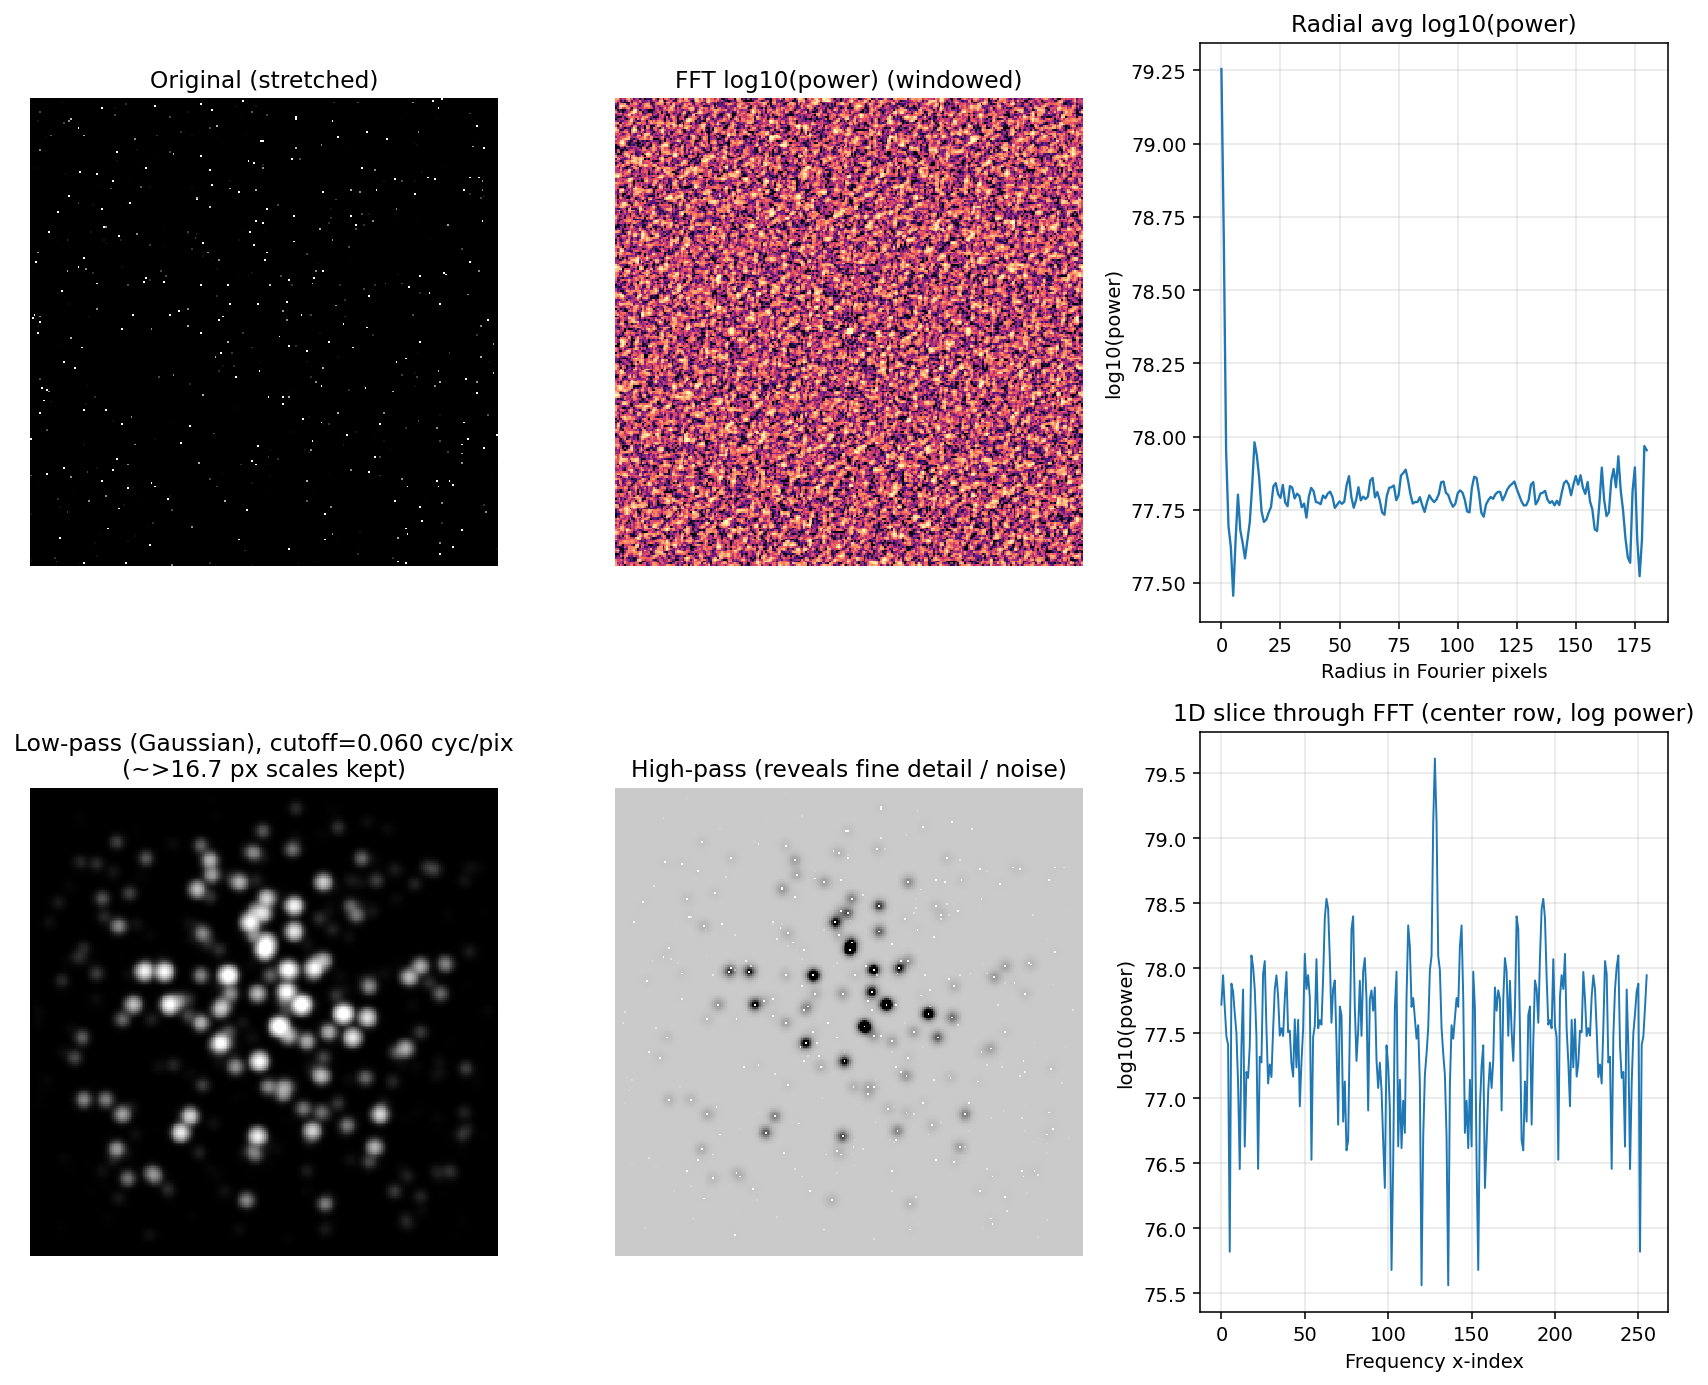

In [3]:
# Advanced Fourier-domain diagnostics + simple frequency filtering
# (Run after your first cell; it will reuse `img` if it exists, otherwise it loads FITS again.)

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch

# ----------------------------
# 0) Get a clean 2D image `img`
# ----------------------------
fits_path = "ngc6503.fits"  # change if needed

def load_first_2d_plane(path, plane_index=0):
    with fits.open(path, memmap=False) as hdul:
        data = hdul[0].data
    if data is None:
        raise ValueError("No image data in primary HDU (hdul[0].data is None)")
    arr = np.squeeze(np.asarray(data))
    if arr.ndim < 2:
        raise ValueError(f"Data has ndim={arr.ndim}, expected at least 2D")
    if arr.ndim == 2:
        img2 = arr
    else:
        ny, nx = arr.shape[-2], arr.shape[-1]
        stack = arr.reshape(-1, ny, nx)
        img2 = stack[int(plane_index)]
        print("Using plane:", plane_index, "from stack shape:", stack.shape)
    img2 = img2.astype(np.float64, copy=False)

    finite = np.isfinite(img2)
    fill = np.median(img2[finite]) if finite.any() else 0.0
    img2 = np.where(finite, img2, fill)
    return img2

if "img" not in globals():
    img = load_first_2d_plane(fits_path, plane_index=0)

ny, nx = img.shape
print("Using img shape:", img.shape)

# Display normalization (same spirit as your first cell)
norm = ImageNormalize(img, interval=PercentileInterval(99.5), stretch=AsinhStretch())

# ----------------------------
# 1) Fourier transform (with windowing to reduce edge effects)
# ----------------------------
# Remove DC background so the FFT isn't dominated by a giant center spike
img0 = img - np.median(img)

# 2D Hann window to reduce spectral leakage from sharp borders
wy = np.hanning(ny)
wx = np.hanning(nx)
window = np.outer(wy, wx)

imgw = img0 * window

F = np.fft.fftshift(np.fft.fft2(imgw))
power = np.abs(F) ** 2

# Log power for visibility
eps = np.finfo(np.float64).eps
log_power = np.log10(power + eps)

# ----------------------------
# 2) Radial (azimuthal) average of power spectrum
#    -> shows "typical" spatial scales / periodic structure
# ----------------------------
yy, xx = np.indices((ny, nx))
cy, cx = (ny - 1) / 2.0, (nx - 1) / 2.0
rr = np.sqrt((yy - cy) ** 2 + (xx - cx) ** 2)

r = rr.ravel()
p = power.ravel()

# Bin by integer radius
r_int = r.astype(np.int32)
max_r = r_int.max()
radial_sum = np.bincount(r_int, weights=p, minlength=max_r + 1)
radial_cnt = np.bincount(r_int, minlength=max_r + 1)
radial_profile = radial_sum / np.maximum(radial_cnt, 1)

# Often useful to look at log profile too
radial_profile_log = np.log10(radial_profile + eps)

# ----------------------------
# 3) Simple frequency-domain filters (Gaussian low-pass / high-pass)
# ----------------------------
# Frequency coordinates in cycles/pixel (centered)
fy = np.fft.fftshift(np.fft.fftfreq(ny))  # [-0.5, 0.5)
fx = np.fft.fftshift(np.fft.fftfreq(nx))
FX, FY = np.meshgrid(fx, fy)
FR = np.sqrt(FX**2 + FY**2)

def gaussian_lowpass(fr, cutoff_cyc_per_pix):
    # Smooth low-pass with "cutoff" controlling how quickly it falls
    # cutoff ~ 0.05 means keep structures larger than ~20 px (since 1/0.05 = 20)
    sigma = cutoff_cyc_per_pix
    return np.exp(-(fr**2) / (2 * sigma**2))

cutoff = 0.06  # tweak: lower -> stronger smoothing; higher -> preserve more detail
LP = gaussian_lowpass(FR, cutoff)
HP = 1.0 - LP

F_lp = F * LP
F_hp = F * HP

img_lp = np.real(np.fft.ifft2(np.fft.ifftshift(F_lp)))
img_hp = np.real(np.fft.ifft2(np.fft.ifftshift(F_hp)))

# Add back a baseline so filtered images are easy to view
baseline = np.median(img)
img_lp += baseline
img_hp += 0.0  # high-pass is around ~0 by design

norm_lp = ImageNormalize(img_lp, interval=PercentileInterval(99.5), stretch=AsinhStretch())
norm_hp = ImageNormalize(img_hp, interval=PercentileInterval(99.5), stretch=AsinhStretch())

# ----------------------------
# 4) Plot: original, FFT (log power), radial profile, filtered views
# ----------------------------
fig = plt.figure(figsize=(12, 10), dpi=140)

ax1 = plt.subplot(2, 3, 1)
ax1.set_title("Original (stretched)")
ax1.axis("off")
ax1.imshow(img, origin="lower", cmap="gray", norm=norm, interpolation="nearest")

ax2 = plt.subplot(2, 3, 2)
ax2.set_title("FFT log10(power) (windowed)")
ax2.axis("off")
# Robust display range for log power
vmin, vmax = np.percentile(log_power, [5, 99.7])
ax2.imshow(log_power, origin="lower", cmap="magma", vmin=vmin, vmax=vmax, interpolation="nearest")

ax3 = plt.subplot(2, 3, 3)
ax3.set_title("Radial avg log10(power)")
ax3.plot(radial_profile_log, lw=1.2)
ax3.set_xlabel("Radius in Fourier pixels")
ax3.set_ylabel("log10(power)")
ax3.grid(True, alpha=0.3)

ax4 = plt.subplot(2, 3, 4)
ax4.set_title(f"Low-pass (Gaussian), cutoff={cutoff:.3f} cyc/pix\n(~>{1/max(cutoff,1e-12):.1f} px scales kept)")
ax4.axis("off")
ax4.imshow(img_lp, origin="lower", cmap="gray", norm=norm_lp, interpolation="nearest")

ax5 = plt.subplot(2, 3, 5)
ax5.set_title("High-pass (reveals fine detail / noise)")
ax5.axis("off")
ax5.imshow(img_hp, origin="lower", cmap="gray", norm=norm_hp, interpolation="nearest")

ax6 = plt.subplot(2, 3, 6)
ax6.set_title("1D slice through FFT (center row, log power)")
center_row = log_power[ny // 2, :]
ax6.plot(center_row, lw=1.0)
ax6.set_xlabel("Frequency x-index")
ax6.set_ylabel("log10(power)")
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tip:
# - If you see bright spikes away from the center in the FFT image, that often indicates periodic artifacts/striping.
# - If the radial profile has bumps/peaks (besides the strong center), that suggests characteristic spatial scales.
